# Looped equation

*NOTE: This file solves the looped equations directly, as opposed to their phi derivatives
in `dphi looped eq (...).ipynb` and `dphi looped integrated.ipynb`

The looped equation `MHD_parsed.eval_loop(n=n_eval)` solves for everything at $n=n_{eval}-1$ (and $B_\psi$ at $n=n_{eval}-3$)

This file uses coefficients from `Validating coefs.ipynb` and `Validating coefs Yn.ipynb`

In [1]:
import jax.numpy as jnp
from functools import partial
from jax import jit, vmap, tree_util

import sys
sys.path.insert(1,'../')
from aqsc import *

from matplotlib import pyplot as plt

In [2]:
equilibrium_test = Equilibrium.load('circular_axis.npy')

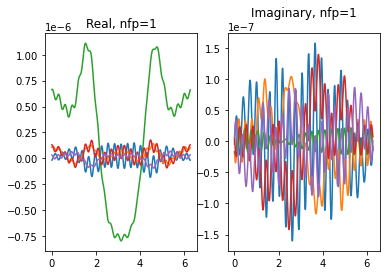

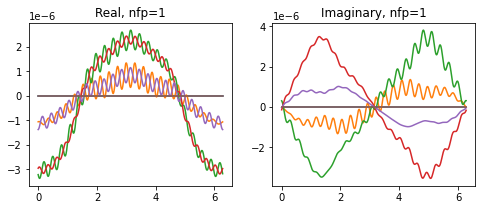

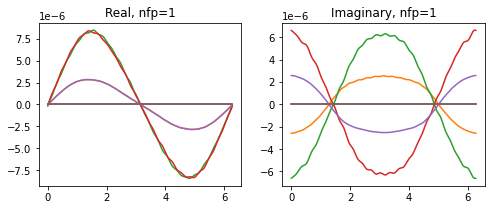

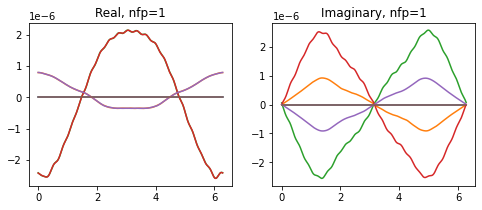

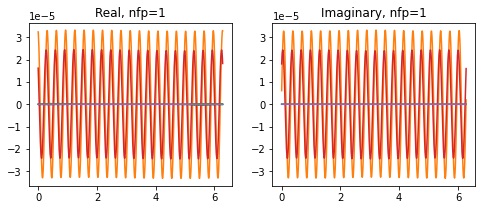

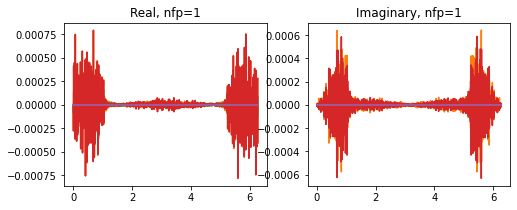

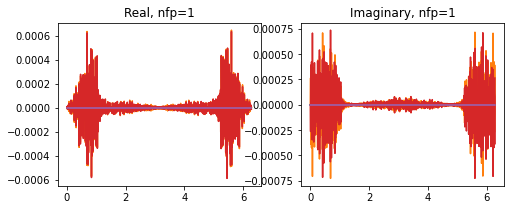

In [3]:
(J, Cb, Ck, Ct, I, II, III) = equilibrium_test.check_governing_equations(4)
J.display_content()
Cb.display_content()
Ck.display_content()
Ct.display_content()
I.display_content()
II.display_content()
III.display_content()

# Usage and masking example of the looped equation (should yield 0)

# Looped source code

In [6]:
%%time
# Compile time: 
# CPU times: user 41min 9s, sys: 44.5 s, total: 41min 54s
# Wall time: 1h 2min 57s
# Run time:
# CPU times: user 1min 38s, sys: 2.73 s, total: 1min 41s
# Wall time: 1min 27s
solution3 = iterate_looped(
    n_unknown=3, max_freq=50, target_len_phi=1000,
    X_coef_cp=equilibrium_test.unknown['X_coef_cp'], 
    Y_coef_cp=equilibrium_test.unknown['Y_coef_cp'], 
    Z_coef_cp=equilibrium_test.unknown['Z_coef_cp'],
    p_perp_coef_cp=equilibrium_test.unknown['p_perp_coef_cp'], 
    Delta_coef_cp=equilibrium_test.unknown['Delta_coef_cp'],
    B_psi_coef_cp=equilibrium_test.unknown['B_psi_coef_cp'], 
    B_theta_coef_cp=equilibrium_test.unknown['B_theta_coef_cp'],
    B_alpha_coef=equilibrium_test.constant['B_alpha_coef'],
    B_denom_coef_c=equilibrium_test.constant['B_denom_coef_c'],
    kap_p=equilibrium_test.constant['kap_p'], 
    tau_p=equilibrium_test.constant['tau_p'], 
    dl_p=equilibrium_test.constant['dl_p'],
    iota_coef=equilibrium_test.constant['iota_coef'],
    nfp=equilibrium_test.nfp,
)

CPU times: user 6.67 s, sys: 3.47 s, total: 10.1 s
Wall time: 14.7 s


In [4]:
def iterate_looped_test(
    n_unknown,
    nfp,
    target_len_phi,
    X_coef_cp, Y_coef_cp, Z_coef_cp,
    p_perp_coef_cp, Delta_coef_cp,
    B_psi_coef_cp, B_theta_coef_cp,
    B_alpha_coef, B_denom_coef_c,
    kap_p, tau_p, dl_p,
    iota_coef,
    # lambda for the coefficient of the scalar free parameter in RHS
    max_freq,
    # B_theta_np10_avg = 0,
    max_k_diff_pre_inv=-1,
    max_k_diff_post_inv=-1
):
    # if target_len_phi<max_freq*2:
    #     raise ValueError('target_len_phi must >= max_freq*2.')
    # First calculate RHS
    out_dict_RHS = generate_RHS(
        n_unknown = n_unknown,
        max_freq = max_freq,
        X_coef_cp = X_coef_cp,
        Y_coef_cp = Y_coef_cp,
        Z_coef_cp = Z_coef_cp,
        p_perp_coef_cp = p_perp_coef_cp,
        Delta_coef_cp = Delta_coef_cp,
        B_psi_coef_cp = B_psi_coef_cp,
        B_theta_coef_cp = B_theta_coef_cp,
        B_alpha_coef = B_alpha_coef,
        B_denom_coef_c = B_denom_coef_c,
        kap_p = kap_p,
        tau_p = tau_p,
        dl_p = dl_p,
        iota_coef = iota_coef
    )
    O_einv = out_dict_RHS['O_einv']
    vector_free_coef = out_dict_RHS['vector_free_coef']
    # Then calculate the inverted differential operators
    filtered_RHS_0_offset = out_dict_RHS['filtered_RHS_0_offset']
    out_dict_tensor = generate_tensor_operator(
        n_unknown = n_unknown,
        nfp = nfp,
        X_coef_cp = X_coef_cp,
        Y_coef_cp = Y_coef_cp,
        Z_coef_cp = Z_coef_cp,
        p_perp_coef_cp = p_perp_coef_cp,
        Delta_coef_cp = Delta_coef_cp,
        B_psi_coef_cp = B_psi_coef_cp,
        B_theta_coef_cp = B_theta_coef_cp,
        B_alpha_coef = B_alpha_coef,
        B_denom_coef_c = B_denom_coef_c,
        kap_p = kap_p,
        tau_p = tau_p,
        dl_p = dl_p,
        iota_coef = iota_coef,
        O_einv = O_einv,
        vector_free_coef = vector_free_coef,
        max_freq = max_freq,
        max_k_diff_pre_inv = max_k_diff_pre_inv,
        max_k_diff_post_inv = max_k_diff_post_inv,
    )
    return(out_dict_RHS, out_dict_tensor)

In [5]:
out_dict_RHS3, out_dict_tensor3 = iterate_looped_test(
    n_unknown=3, max_freq=50, target_len_phi=1000,
    X_coef_cp=equilibrium_test.unknown['X_coef_cp'], 
    Y_coef_cp=equilibrium_test.unknown['Y_coef_cp'], 
    Z_coef_cp=equilibrium_test.unknown['Z_coef_cp'],
    p_perp_coef_cp=equilibrium_test.unknown['p_perp_coef_cp'], 
    Delta_coef_cp=equilibrium_test.unknown['Delta_coef_cp'],
    B_psi_coef_cp=equilibrium_test.unknown['B_psi_coef_cp'], 
    B_theta_coef_cp=equilibrium_test.unknown['B_theta_coef_cp'],
    B_alpha_coef=equilibrium_test.constant['B_alpha_coef'],
    B_denom_coef_c=equilibrium_test.constant['B_denom_coef_c'],
    kap_p=equilibrium_test.constant['kap_p'], 
    tau_p=equilibrium_test.constant['tau_p'], 
    dl_p=equilibrium_test.constant['dl_p'],
    iota_coef=equilibrium_test.constant['iota_coef'],
    nfp=equilibrium_test.nfp,
)

NameError: name 'solution3' is not defined

In [8]:
np.save('out_dict_RHS3',out_dict_RHS3)
np.save('out_dict_tensor3',out_dict_tensor3)
np.save('solution3',solution3)

In [5]:
out_dict_RHS3 = np.load('out_dict_RHS3.npy',allow_pickle=True).item()
out_dict_tensor3 = np.load('out_dict_tensor3.npy',allow_pickle=True).item()
solution3 = np.load('solution3.npy',allow_pickle=True).item()

ModuleNotFoundError: No module named 'jax._src.device_array'

# Finding the correct row to add 
Finding a matrix with shape `(1, len_phi, len_chi_sln, len_phi)` that obtains the avg of $B_\theta$.

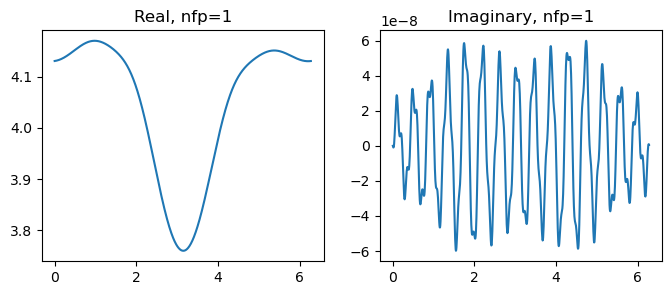

Avg B_theta: (4.048609495991457+3.4350126740148156e-16j)


In [18]:
# B_theta
solution3['B_theta_np10'].display_content()
print('Avg B_theta:', jnp.average(solution3['B_theta_np10'].content))

In [19]:
# B_theta_avg_operator
len_phi = 1000
n_unknown = 3
new_row = jnp.zeros((1, len_phi, n_unknown+1, len_phi))
new_row = new_row.at[0, :, -1, 0].set(1)
# The output of this cell should all be the average of B_theta n+1.
# jnp.tensordot(new_row, jnp.fft.fft(solution3['solution'],axis=1)/len_phi)


# A new version of new rows that is derived from the adjavent row.

In [20]:
out_dict_tensor3.keys()

dict_keys(['tensor_fft_op_B_psi_in_Y', 'filtered_looped_fft_operator', 'filtered_inv_looped_fft_operator'])

In [21]:
len_phi = out_dict_tensor3['filtered_looped_fft_operator'].shape[1]
# Compare the results produced by applying the operator to the 
# full solution or one with just the B_theta[n+1,0] average element
filtered_solution = fft_filter(jnp.fft.fft(solution3['solution'],axis=1),100,axis=1)
filtered_solution_flattened = filtered_solution.flatten()

In [23]:
filtered_looped_fft_operator = out_dict_tensor3['filtered_looped_fft_operator']
filtered_looped_fft_operator_flattened = jnp.reshape(
    filtered_looped_fft_operator, 
    (
        filtered_looped_fft_operator.shape[0]*filtered_looped_fft_operator.shape[1],
        filtered_looped_fft_operator.shape[2]*filtered_looped_fft_operator.shape[3]
    )
)
filtered_looped_fft_operator_overdet = jnp.concatenate(
    (filtered_looped_fft_operator_flattened, new_row[None, :]), 
    axis=0
)

In [24]:
# Penalty for deviation from a given average
new_row = jnp.zeros((n_unknown+1)*len_phi)
penalty_weight = jnp.max(jnp.abs(filtered_looped_fft_operator))
new_row = new_row.at[-len_phi].set(penalty_weight)

In [25]:
B_theta_np1_0_avg = 0 # new_row@filtered_solution_flattened # (len_phi*desired val)

In [26]:
filtered_RHS_0_offset = out_dict_RHS3['filtered_RHS_0_offset']
RHS_flattened = jnp.concatenate((filtered_RHS_0_offset.flatten(), jnp.array([B_theta_np1_0_avg])))

In [27]:
jnp.max(jnp.abs(filtered_looped_fft_operator))

DeviceArray(574452.00069015, dtype=float64)

In [28]:
filtered_solution_flattened.shape

(400,)

In [29]:
jnp.all(jnp.isclose(filtered_looped_fft_operator_overdet@filtered_solution_flattened, RHS_flattened))

DeviceArray(True, dtype=bool)

In [30]:
svd_solution_flattened = linear_least_sq_2d_svd(filtered_looped_fft_operator_overdet, RHS_flattened)

/Users/lanke/anaconda3/envs/nae/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


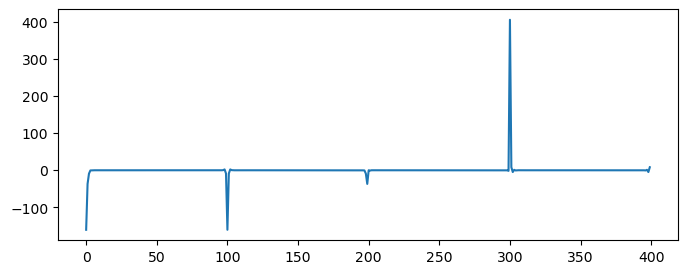

In [31]:
plt.plot(filtered_solution_flattened)

In [32]:
solution_guess_fft = jnp.reshape(svd_solution_flattened, (4,100))
solution_guess = jnp.fft.ifft(solution_guess_fft, axis=1)

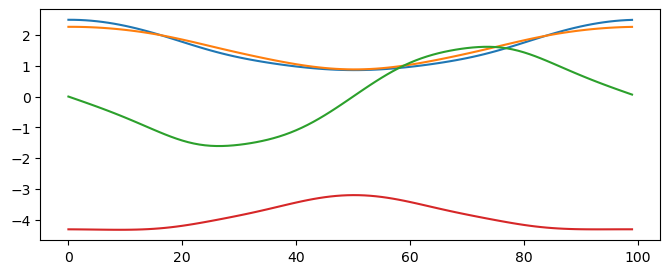

In [33]:
plt.plot(solution_guess.T)

In [34]:
max_freq = len_phi//2
nfp = 1
out_dict_RHS = out_dict_RHS3
out_dict_tensor = out_dict_tensor3
target_len_phi = 1000
O_einv = out_dict_RHS3['O_einv']
vector_free_coef = out_dict_RHS3['vector_free_coef']

X_coef_cp=equilibrium_test.unknown['X_coef_cp'] 
Y_coef_cp=equilibrium_test.unknown['Y_coef_cp'] 
Z_coef_cp=equilibrium_test.unknown['Z_coef_cp']
p_perp_coef_cp=equilibrium_test.unknown['p_perp_coef_cp'] 
Delta_coef_cp=equilibrium_test.unknown['Delta_coef_cp']
B_psi_coef_cp=equilibrium_test.unknown['B_psi_coef_cp'] 
B_theta_coef_cp=equilibrium_test.unknown['B_theta_coef_cp']
B_alpha_coef=equilibrium_test.constant['B_alpha_coef']
B_denom_coef_c=equilibrium_test.constant['B_denom_coef_c']
kap_p=equilibrium_test.constant['kap_p'] 
tau_p=equilibrium_test.constant['tau_p'] 
dl_p=equilibrium_test.constant['dl_p']
iota_coef=equilibrium_test.constant['iota_coef']


solution = jnp.fft.ifft(fft_pad(solution_guess_fft, 1000, axis=1), axis=1)

B_theta_n = ChiPhiFunc(solution[:-2], nfp)
B_theta_in_B_psi = n_unknown/2*B_theta_n.antid_chi()
B_theta_in_B_psi_fft_short=fft_filter(B_theta_in_B_psi.fft().content, max_freq*2, axis=1)

B_psi_nm2 = out_dict_RHS['B_psi_nm2_no_unknown'] + B_theta_in_B_psi

# Calculating Yn
vec_free = solution[-2]
Yn_rhs_content_no_unknown = out_dict_RHS['Yn_rhs_content_no_unknown']
Yn_B_theta_terms = ChiPhiFunc(
    fft_pad(
        jnp.einsum(
            'ijkl, jl -> ik',
            out_dict_tensor['tensor_fft_op_B_psi_in_Y'],
            B_theta_in_B_psi_fft_short
        ),
        target_len_phi,
        axis=1
    ),
    nfp
).ifft()
Yn = ChiPhiFunc(
    jnp.einsum('ijk,jk->ik',O_einv,out_dict_RHS['Yn_rhs_content_no_unknown'])
    + vec_free * vector_free_coef,
    nfp
) + Yn_B_theta_terms

Zn = (
    out_dict_RHS['Zn_no_B_theta']
    +looped_coefs.lambda_B_psi_nm2_in_Z_n(
        X_coef_cp=X_coef_cp,
        Y_coef_cp=Y_coef_cp,
        B_theta_coef_cp=B_theta_coef_cp,
        B_psi_coef_cp=B_psi_coef_cp,
        iota_coef=iota_coef,
        p_perp_coef_cp=p_perp_coef_cp,
        Delta_coef_cp=Delta_coef_cp,
        B_denom_coef_c=B_denom_coef_c,
        B_alpha_coef=B_alpha_coef,
        kap_p=kap_p,
        dl_p=dl_p,
        tau_p=tau_p,
        n_eval=n_unknown+1)*B_theta_in_B_psi
)
pn = (
    out_dict_RHS['pn_no_B_theta']
    +looped_coefs.lambda_B_psi_nm2_in_p_n(
        X_coef_cp=X_coef_cp,
        Y_coef_cp=Y_coef_cp,
        B_theta_coef_cp=B_theta_coef_cp,
        B_psi_coef_cp=B_psi_coef_cp,
        iota_coef=iota_coef,
        p_perp_coef_cp=p_perp_coef_cp,
        Delta_coef_cp=Delta_coef_cp,
        B_denom_coef_c=B_denom_coef_c,
        B_alpha_coef=B_alpha_coef,
        kap_p=kap_p,
        dl_p=dl_p,
        tau_p=tau_p,
        n_eval=n_unknown+1)*B_theta_in_B_psi
    +looped_coefs.lambda_dchi_B_psi_nm2_in_p_n(
        X_coef_cp=X_coef_cp,
        Y_coef_cp=Y_coef_cp,
        B_theta_coef_cp=B_theta_coef_cp,
        B_psi_coef_cp=B_psi_coef_cp,
        iota_coef=iota_coef,
        p_perp_coef_cp=p_perp_coef_cp,
        Delta_coef_cp=Delta_coef_cp,
        B_denom_coef_c=B_denom_coef_c,
        B_alpha_coef=B_alpha_coef,
        kap_p=kap_p,
        dl_p=dl_p,
        tau_p=tau_p,
        n_eval=n_unknown+1)*B_theta_in_B_psi.dchi()
    +looped_coefs.lambda_dphi_B_psi_nm2_in_p_n(
        X_coef_cp=X_coef_cp,
        Y_coef_cp=Y_coef_cp,
        B_theta_coef_cp=B_theta_coef_cp,
        B_psi_coef_cp=B_psi_coef_cp,
        iota_coef=iota_coef,
        p_perp_coef_cp=p_perp_coef_cp,
        Delta_coef_cp=Delta_coef_cp,
        B_denom_coef_c=B_denom_coef_c,
        B_alpha_coef=B_alpha_coef,
        kap_p=kap_p,
        dl_p=dl_p,
        tau_p=tau_p,
        n_eval=n_unknown+1)*B_theta_in_B_psi.dphi()
)
Xn = (
    out_dict_RHS['Xn_no_B_theta']
    +looped_coefs.lambda_B_psi_nm2_in_X_n(
        X_coef_cp=X_coef_cp,
        Y_coef_cp=Y_coef_cp,
        B_theta_coef_cp=B_theta_coef_cp,
        B_psi_coef_cp=B_psi_coef_cp,
        iota_coef=iota_coef,
        p_perp_coef_cp=p_perp_coef_cp,
        Delta_coef_cp=Delta_coef_cp,
        B_denom_coef_c=B_denom_coef_c,
        B_alpha_coef=B_alpha_coef,
        kap_p=kap_p,
        dl_p=dl_p,
        tau_p=tau_p,
        n_eval=n_unknown+1)*B_theta_in_B_psi
    +looped_coefs.lambda_dchi_B_psi_nm2_in_X_n(
        X_coef_cp=X_coef_cp,
        Y_coef_cp=Y_coef_cp,
        B_theta_coef_cp=B_theta_coef_cp,
        B_psi_coef_cp=B_psi_coef_cp,
        iota_coef=iota_coef,
        p_perp_coef_cp=p_perp_coef_cp,
        Delta_coef_cp=Delta_coef_cp,
        B_denom_coef_c=B_denom_coef_c,
        B_alpha_coef=B_alpha_coef,
        kap_p=kap_p,
        dl_p=dl_p,
        tau_p=tau_p,
        n_eval=n_unknown+1)*B_theta_in_B_psi.dchi()
    +looped_coefs.lambda_dphi_B_psi_nm2_in_X_n(
        X_coef_cp=X_coef_cp,
        Y_coef_cp=Y_coef_cp,
        B_theta_coef_cp=B_theta_coef_cp,
        B_psi_coef_cp=B_psi_coef_cp,
        iota_coef=iota_coef,
        p_perp_coef_cp=p_perp_coef_cp,
        Delta_coef_cp=Delta_coef_cp,
        B_denom_coef_c=B_denom_coef_c,
        B_alpha_coef=B_alpha_coef,
        kap_p=kap_p,
        dl_p=dl_p,
        tau_p=tau_p,
        n_eval=n_unknown+1)*B_theta_in_B_psi.dphi()
)
Deltan = (
    out_dict_RHS['Deltan_no_B_theta']
    -looped_coefs.lambda_B_psi_nm2_in_p_n(
        X_coef_cp=X_coef_cp,
        Y_coef_cp=Y_coef_cp,
        B_theta_coef_cp=B_theta_coef_cp,
        B_psi_coef_cp=B_psi_coef_cp,
        iota_coef=iota_coef,
        p_perp_coef_cp=p_perp_coef_cp,
        Delta_coef_cp=Delta_coef_cp,
        B_denom_coef_c=B_denom_coef_c,
        B_alpha_coef=B_alpha_coef,
        kap_p=kap_p,
        dl_p=dl_p,
        tau_p=tau_p,
        n_eval=n_unknown+1)*B_denom_coef_c[0]*B_theta_in_B_psi
    -looped_coefs.lambda_dchi_B_psi_nm2_in_p_n(
        X_coef_cp=X_coef_cp,
        Y_coef_cp=Y_coef_cp,
        B_theta_coef_cp=B_theta_coef_cp,
        B_psi_coef_cp=B_psi_coef_cp,
        iota_coef=iota_coef,
        p_perp_coef_cp=p_perp_coef_cp,
        Delta_coef_cp=Delta_coef_cp,
        B_denom_coef_c=B_denom_coef_c,
        B_alpha_coef=B_alpha_coef,
        kap_p=kap_p,
        dl_p=dl_p,
        tau_p=tau_p,
        n_eval=n_unknown+1)*B_denom_coef_c[0]*B_theta_in_B_psi.dchi()
    -looped_coefs.lambda_dphi_B_psi_nm2_in_p_n(
        X_coef_cp=X_coef_cp,
        Y_coef_cp=Y_coef_cp,
        B_theta_coef_cp=B_theta_coef_cp,
        B_psi_coef_cp=B_psi_coef_cp,
        iota_coef=iota_coef,
        p_perp_coef_cp=p_perp_coef_cp,
        Delta_coef_cp=Delta_coef_cp,
        B_denom_coef_c=B_denom_coef_c,
        B_alpha_coef=B_alpha_coef,
        kap_p=kap_p,
        dl_p=dl_p,
        tau_p=tau_p,
        n_eval=n_unknown+1)*B_denom_coef_c[0]*B_theta_in_B_psi.dphi()
)
return_dict = {
    'B_theta_n': B_theta_n.filter(max_freq),
    'B_theta_np10': ChiPhiFunc(jnp.array([solution[-1]]), nfp),
    # These filters are here because dphi and B_theta_in_B_psi still produce error
    'B_psi_nm2': B_psi_nm2.filter(max_freq),
    'Yn': Yn.filter(max_freq),
    'Xn': Xn.filter(max_freq),
    'Zn': Zn.filter(max_freq),
    'pn': pn.filter(max_freq),
    'Deltan': Deltan.filter(max_freq),
    # 'Yn_B_theta_terms': Yn_B_theta_terms,
    # 'Yn1p': vec_free,
    'solution': solution,
    # 'out_dict_RHS':out_dict_RHS,
    # 'out_dict_tensor':out_dict_tensor,
}

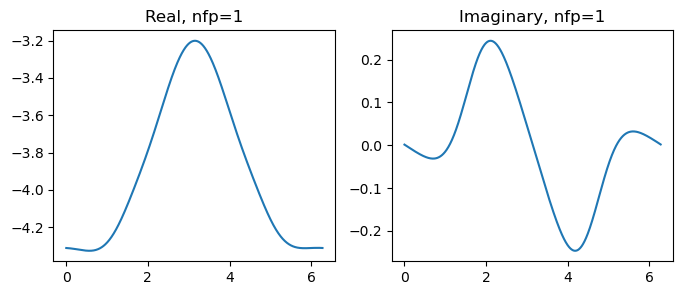

In [35]:
return_dict['B_theta_np10'].display_content()

In [36]:
B_theta_coef_cp.get_order()

4

In [37]:
B_theta_coef_cp_test = B_theta_coef_cp.mask(2).append(return_dict['B_theta_n']) # .filter(max_freq[0]))
B_psi_coef_cp_test = B_psi_coef_cp.mask(0).append(return_dict['B_psi_nm2']) # .filter(max_freq[0]))
X_coef_cp_test = X_coef_cp.mask(2).append(return_dict['Xn']) # .filter(max_freq[0]))
Y_coef_cp_test = Y_coef_cp.mask(2).append(return_dict['Yn']) # .filter(max_freq[0]))
Z_coef_cp_test = Z_coef_cp.mask(2).append(return_dict['Zn']) # .filter(max_freq[0]))
p_perp_coef_cp_test = p_perp_coef_cp.mask(2).append(return_dict['pn']) # .filter(max_freq[0]))
Delta_coef_cp_test = Delta_coef_cp.mask(2).append(return_dict['Deltan']) # .filter(max_freq[0]))

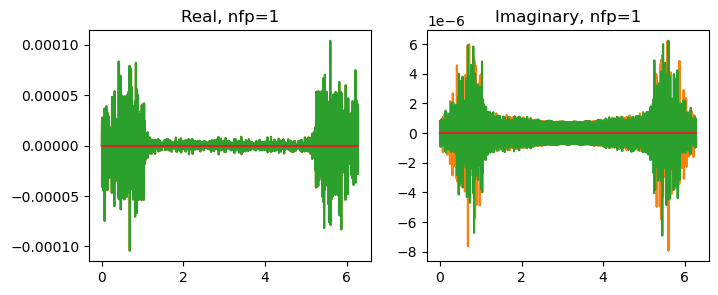

In [38]:
II = MHD_parsed.validate_II(
    3,
    B_theta_coef_cp, B_alpha_coef, B_denom_coef_c,
    p_perp_coef_cp, Delta_coef_cp, iota_coef
)
II.display_content()

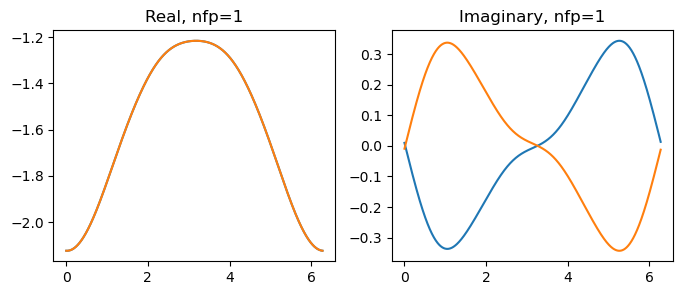

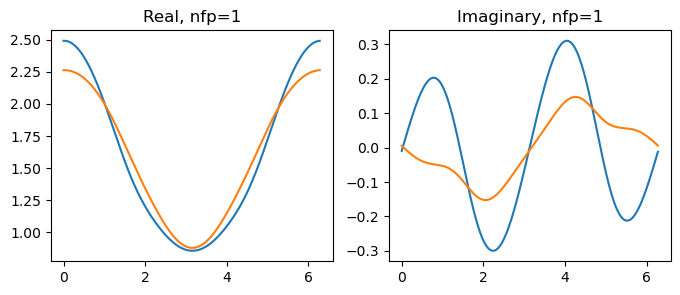

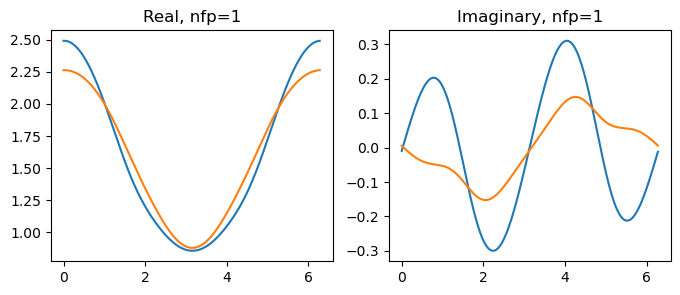

In [39]:
B_theta_coef_cp[3].display_content()
B_theta_coef_cp_test[3].display_content()
B_theta_n.display_content()

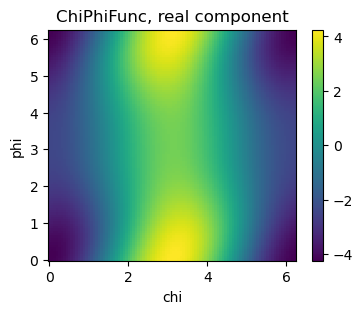

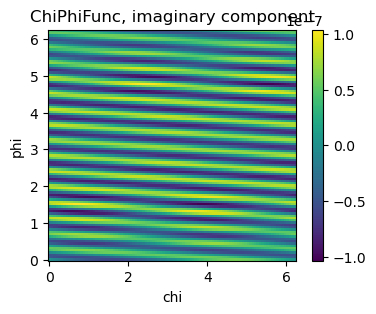

In [40]:
B_theta_coef_cp[3].display(complex=True)

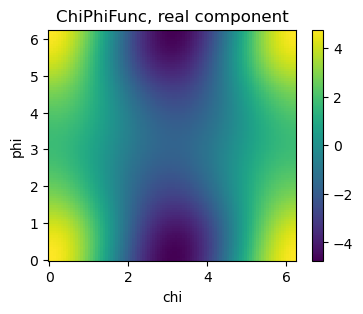

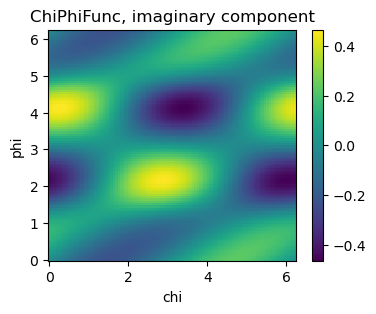

In [41]:
B_theta_n.display(complex=True)

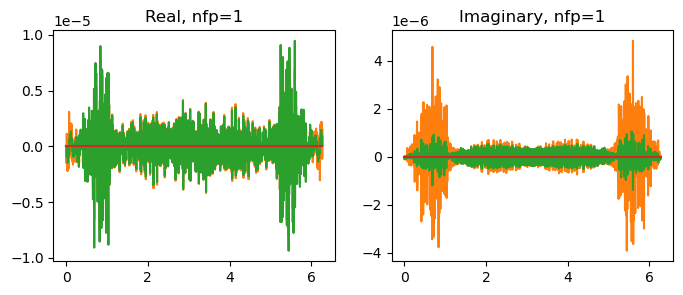

In [42]:
II_svd = MHD_parsed.validate_II(
    3,
    B_theta_coef_cp_test,
    B_alpha_coef,
    B_denom_coef_c,
    p_perp_coef_cp_test,
    Delta_coef_cp_test,
    iota_coef
)
II_svd.display_content()

ck


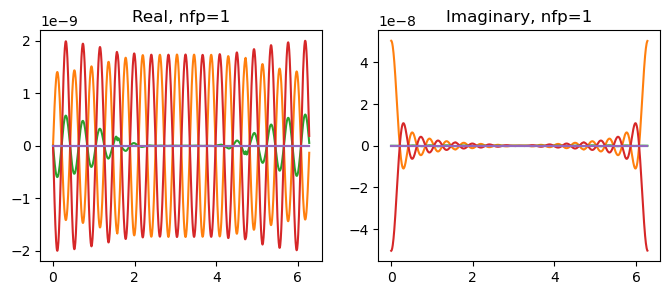

ct


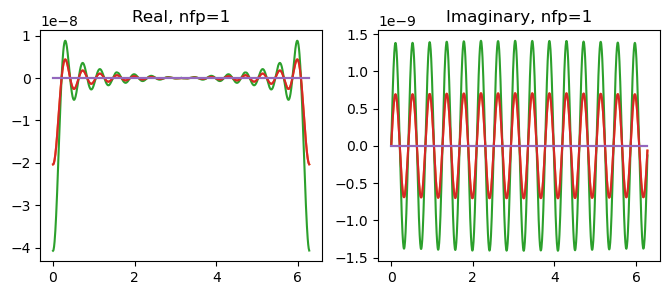

i


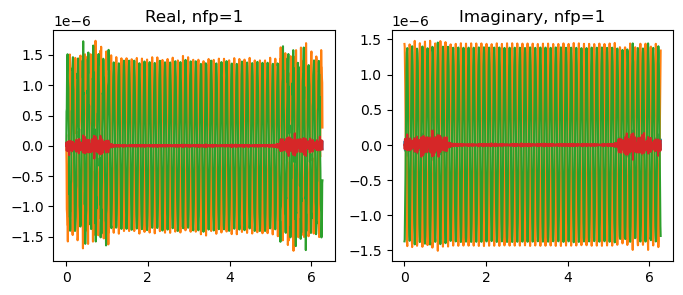

iii


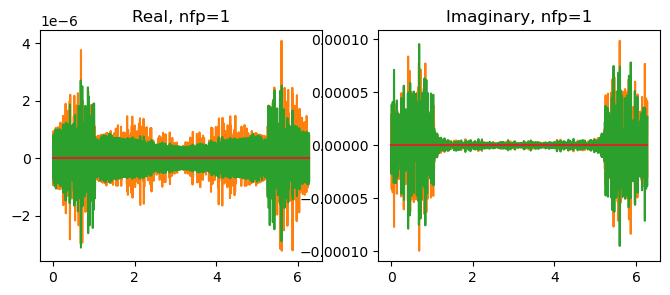

In [43]:
print('ck')
MHD_parsed.validate_Ck(
    2, 
    X_coef_cp_test, 
    Y_coef_cp_test, 
    Z_coef_cp_test,
    B_denom_coef_c, B_alpha_coef,
    B_psi_coef_cp_test, B_theta_coef_cp_test,
    kap_p, dl_p, tau_p, iota_coef
).display_content()

print('ct')
MHD_parsed.validate_Ct(
    2, 
    X_coef_cp_test, 
    Y_coef_cp_test, 
    Z_coef_cp_test,
    B_denom_coef_c, 
    B_alpha_coef,
    B_psi_coef_cp_test, 
    B_theta_coef_cp_test,
    kap_p, dl_p, tau_p, iota_coef
).display_content()
print('i')
MHD_parsed.validate_I(3, B_denom_coef_c,
    p_perp_coef_cp_test, Delta_coef_cp_test,
    iota_coef).display_content()
print('iii')
III = MHD_parsed.validate_III(1,
    B_theta_coef_cp_test, B_psi_coef_cp_test,
    B_alpha_coef, B_denom_coef_c,
    p_perp_coef_cp_test, Delta_coef_cp_test,
    iota_coef).display_content()

# It appears the linear optimization approach produces complex solutions. 
To resolve this issue, we solve the operator in trig representation.
Problem: This will be difficult because you'll have to use Y1s instead pf Y1p!

In [44]:
filtered_looped_fft_operator.shape

(4, 100, 4, 100)

In [68]:
a = [1,2,3,4]

In [69]:
a[:2]

[1, 2]

In [116]:
# First, we need to convert B_theta[n]'s 
# Chi dependence to and from trig representation.
# This involves the first n components.
# This is unnecessary for Yn1 and B_theta[n+1, 0]
# (the last two components)

trig_to_exp_op_B_theta = trig_to_exp_op(n_unknown-1)
exp_to_trig_op_B_theta = exp_to_trig_op(n_unknown-1)
exp_to_trig_op_RHS = exp_to_trig_op(n_unknown+1)

# To transform L acting on and producing vectors in exp representation
# to L' acting on and producing vectors in trig representation, 
# L' = A@L@B,
# A = exp_to_trig_op_RHS
# B = [
#     trig_to_exp_op_B_theta, 0's, 0
#     0's,                    1,   0 
#     0's,                    0,   1
#     ]
# L'x'=b'
# x' = inv(B)@x
# b' = A@b

matrix_A = exp_to_trig_op_RHS
matrix_B = jnp.identity(n_unknown+1, dtype = exp_to_trig_op_B_theta.dtype)
matrix_B = matrix_B.at[:n_unknown-1, :n_unknown-1].set(exp_to_trig_op_B_theta)

In [124]:
# The operator acting on unknowns in trig representation is
# (exp_to_trig_op_n_unknown @ filtered_looped_fft_operator) @ trig_to_exp_op_n_unknown
filtered_looped_fft_operator_trig = jnp.einsum('mi,ijkl->mjkl', matrix_A, filtered_looped_fft_operator)
filtered_looped_fft_operator_trig = jnp.einsum('ijkl,km->ijml', filtered_looped_fft_operator_trig, matrix_B)

# NOTE!!!!!!!!! this doesn't work yet because Y_free is set to Y1p. Y1c code is just written but not tested. TEST IT and then we can solve the whole thing in trig ch representation. remember to note in comments that the rest of the algebra was done in exponential because it's simpler to program, and the reason we use trig is that SVD doesn't produce real results anymore. Could this lead to a good, real solution with specified B_theta average? We don't know. SVD makes it easier to constrain other quantities, also! Remember to rename filtered_RHS_0_offset to something more readable, now that solve_free_param is gradually phased out.

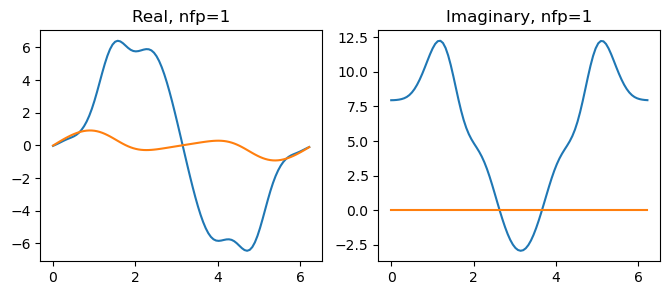

In [135]:
ChiPhiFunc(jnp.fft.ifft(filtered_RHS_0_offset[:2],axis=1), 1).display_content()

In [132]:
jnp.max(jnp.imag(exp_to_trig_op_RHS@filtered_RHS_0_offset))

DeviceArray(604.83303708, dtype=float64)

In [127]:
trig_RHS = jnp.tensordot(filtered_looped_fft_operator_trig, jnp.linalg.inv(matrix_B)@filtered_solution)

In [129]:
jnp.isclose(trig_RHS, exp_to_trig_op_RHS@filtered_RHS_0_offset)

DeviceArray([[ True,  True,  True,  True,  True,  True,  True,  True,
               True,  True,  True,  True,  True,  True,  True,  True,
               True,  True,  True,  True,  True,  True,  True,  True,
               True,  True,  True,  True,  True,  True,  True,  True,
               True,  True,  True,  True,  True,  True,  True,  True,
               True,  True,  True,  True,  True,  True,  True,  True,
               True,  True,  True,  True,  True,  True,  True,  True,
               True,  True,  True,  True,  True,  True,  True,  True,
               True,  True,  True,  True,  True,  True,  True,  True,
               True,  True,  True,  True,  True,  True,  True,  True,
               True,  True,  True,  True,  True,  True,  True,  True,
               True,  True,  True,  True,  True,  True,  True,  True,
               True,  True,  True,  True],
             [ True,  True,  True,  True,  True,  True,  True,  True,
               True,  True,  True,  True,  True